# Lesson 5: Transformers

*Teachers:* Fares Schulz, Lina Campanella

In this course we will cover:

## Bach Chorale Generation with Transformers

Now let's train our Transformer on Bach chorales and compare it with the RNN approach. We'll use the same JSB Chorales dataset but leverage the Transformer's attention mechanism for better long-range dependencies.

In [144]:
import urllib.request
import tarfile
from pathlib import Path
import pandas as pd

# Download the dataset using urllib and extract with tarfile
download_link = "https://github.com/iCorv/jsb-chorales-dataset/raw/main/jsb_chorales.tar"
data_dir = Path('resources/_data/jsb_chorales')
tar_path = data_dir / 'jsb_chorales.tar'

# Create directory if it doesn't exist
data_dir.mkdir(parents=True, exist_ok=True)

# Download the file if it doesn't already exist
if not tar_path.exists():
    print(f"Downloading dataset from {download_link}")
    urllib.request.urlretrieve(download_link, tar_path)
    print(f"Downloaded to {tar_path}")
else:
    print(f"Dataset already exists at {tar_path}")

# Extract the tar file
if tar_path.exists() and not (data_dir / 'jsb_chorales').exists():
    print(f"Extracting {tar_path}")
    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(path=data_dir)
    print(f"Extracted to {data_dir}")

filepath = str(tar_path)
print(f"Dataset available at: {filepath}")

Dataset already exists at resources/_data/jsb_chorales/jsb_chorales.tar
Extracting resources/_data/jsb_chorales/jsb_chorales.tar
Extracted to resources/_data/jsb_chorales
Dataset available at: resources/_data/jsb_chorales/jsb_chorales.tar


In [145]:
jsb_chorales_dir = Path(filepath).parent
train_files = sorted(jsb_chorales_dir.glob("train/chorale_*.csv"))
valid_files = sorted(jsb_chorales_dir.glob("valid/chorale_*.csv"))
test_files = sorted(jsb_chorales_dir.glob("test/chorale_*.csv"))

In [146]:
def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]

train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [147]:
notes = set()
for chorales in (train_chorales, valid_chorales, test_chorales):
    for chorale in chorales:
        for chord in chorale:
            notes |= set(chord)

n_notes = len(notes)
min_note = min(notes - {0})
max_note = max(notes)

assert min_note == 36
assert max_note == 81

In [148]:
from resources._code.synthesizer import SimpleSynth

baroque_synth = SimpleSynth(tempo=160, amplitude=0.1, sample_rate=44100, baroque_tuning=True)

In [149]:
import torch
from torch.utils.data import Dataset, DataLoader

def preprocess(window):
    # Shift values: keep 0 as 0 (silence), shift other notes to start from 1
    window = torch.where(window == 0, window, window - min_note + 1)
    return window.reshape(-1)  # convert to arpeggio (flatten to 1D sequence)

class BachDataset(Dataset):
    def __init__(self, chorales, window_size=32, window_shift=16):
        self.chorales = chorales
        self.window_size = window_size
        self.window_shift = window_shift
        self.windows = self._create_windows()
    
    def _create_windows(self):
        windows = []
        for chorale in self.chorales:
            chorale_tensor = torch.tensor(chorale, dtype=torch.long)
            
            # Create sliding windows
            for i in range(0, len(chorale) - self.window_size, self.window_shift):
                window = chorale_tensor[i:i + self.window_size + 1]
                if len(window) == self.window_size + 1:  # Ensure full window
                    windows.append(window)
        
        return windows
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        window = self.windows[idx]
        # Preprocess: shift note values and flatten
        preprocessed = preprocess(window)
        
        # Create input/target pairs 
        X = preprocessed[:-1]
        Y = preprocessed[1:] # predict next note in each arpegio, at each step
        
        return X, Y

def bach_dataloader(chorales, batch_size=32, shuffle=False, window_size=32, window_shift=16):
    
    dataset = BachDataset(chorales, window_size, window_shift)
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataloader


In [150]:
# load the datasets
train_set = bach_dataloader(train_chorales, shuffle=True)
valid_set = bach_dataloader(valid_chorales)
test_set = bach_dataloader(test_chorales)

In [151]:
import torch
import torch.nn as nn
import math


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=256, num_heads=4):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.Wv = nn.Linear(d_model, d_model, bias=False) # the Value parameters
        self.Wk = nn.Linear(d_model, d_model, bias=False) # the Key parameters
        self.Wq = nn.Linear(d_model, d_model, bias=False) # the Query parameters
        self.Wo = nn.Linear(d_model, d_model, bias=False) # the output parameters


    def scaled_dot_product_attention(self, query, key, value, attention_mask=None, key_padding_mask=None):        
        d_k = query.size(-1)
        tgt_len, src_len = query.size(-2), key.size(-2)

        # logits = query * key^T / sqrt(d_k)
        logits = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) 

        # Attention mask here
        if attention_mask is not None:
            if attention_mask.dim() == 2:
                assert attention_mask.size() == (tgt_len, src_len)
                attention_mask = attention_mask.unsqueeze(0)
                logits = logits + attention_mask
            else:
                raise ValueError(f"Attention mask size {attention_mask.size()}")
                
        # Key mask here
        if key_padding_mask is not None:
            key_padding_mask = key_padding_mask.unsqueeze(1).unsqueeze(2) # Broadcast over batch size, num heads
            logits = logits + key_padding_mask
        
        attention = torch.softmax(logits, dim=-1)
        output = torch.matmul(attention, value) # (batch_size, num_heads, sequence_length, head_dim)
        
        return output, attention

    
    def split_into_heads(self, x):
        batch_size, seq_length, _ = x.size()
        x = x.view(batch_size, seq_length, self.num_heads, self.head_dim)
        return x.transpose(1, 2) # Final dim will be (batch_size, num_heads, seq_length, head_dim)

    def combine_heads(self, x):
        batch_size, _, seq_length, _ = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    
    def forward(self, q, k, v, attention_mask=None, key_padding_mask=None):
   
        q = self.Wq(q) # (batch_size, query_sequence_length, d_model)
        k = self.Wk(k) # (batch_size, key_sequence_length, d_model)
        v = self.Wv(v) # (batch_size, key_sequence_length, d_model)

        q = self.split_into_heads(q)
        k = self.split_into_heads(k)
        v = self.split_into_heads(v)
        
        attention_values, attention_weights  = self.scaled_dot_product_attention(query=q, key=k, value=v, attention_mask=attention_mask, key_padding_mask=key_padding_mask)
        grouped = self.combine_heads(attention_values)
        output = self.Wo(grouped)
        
        self.attention_weights = attention_weights
        
        return output

In [152]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

In [153]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden_dim=None):
        super().__init__()
        if hidden_dim is None:
            hidden_dim = 4 * d_model  # Standard 4x expansion
        self.fc1 = nn.Linear(d_model, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, d_model)
        self.relu = nn.ReLU()


    def forward(self, x):        
        return self.fc2(self.relu(self.fc1(x)))

In [164]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, dropout, num_heads):
        super().__init__()
        
        # The first Multi-Head Attention has a mask to avoid looking at the future
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        
        self.ff = PositionWiseFeedForward(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Add proper dropout layers
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout) 
        
        
    def forward(self, tgt, tgt_mask=None, tgt_padding_mask=None):
        masked_att_output = self.self_attention(q=self.norm1(tgt), k=self.norm1(tgt), v=self.norm1(tgt), attention_mask=tgt_mask, key_padding_mask=tgt_padding_mask)
        x = tgt + self.dropout1(masked_att_output)
        
        ff_output = self.ff(self.norm2(x))
        output = x + self.dropout2(ff_output)

        return output
    

    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, dropout, num_decoder_blocks, num_heads, shared_embedding):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.embedding = shared_embedding
        # self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model, padding_idx=0)
        self.positional_encoding = PositionalEncoding(d_model=d_model, dropout=dropout)
          
        self.decoder_blocks = nn.ModuleList([DecoderBlock(d_model, dropout, num_heads) for _ in range(num_decoder_blocks)])
        
        
    def forward(self, tgt, tgt_mask=None, tgt_padding_mask=None):
        x = self.embedding(tgt) * math.sqrt(self.d_model)
        x = self.positional_encoding(x)

        for block in self.decoder_blocks:
            x = block(x, tgt_mask=tgt_mask, tgt_padding_mask=tgt_padding_mask)
            
        return x

In [165]:
class Transformer(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        
        for k, v in kwargs.items():
            print(f" * {k}={v}")
        
        self.n_notes = kwargs.get('n_notes')
        self.d_model = kwargs.get('d_model', kwargs.get('model_dim'))  # Support both names
        self.dropout = kwargs.get('dropout')
        self.n_decoder_layers = kwargs.get('n_decoder_layers')
        self.n_heads = kwargs.get('n_heads')
        self.batch_size = kwargs.get('batch_size')

        self.shared_embedding = nn.Embedding(self.n_notes, self.d_model)

        self.decoder = Decoder(self.n_notes, self.d_model, self.dropout, self.n_decoder_layers, self.n_heads, self.shared_embedding)
        self.fc = nn.Linear(self.d_model, self.n_notes)
        self.fc.weight = self.shared_embedding.weight  # Weight sharing!

        

    @staticmethod    
    def generate_square_subsequent_mask(size, device=None):
            mask = (1 - torch.triu(torch.ones(size, size, device=device), diagonal=1)).bool()
            mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
            return mask

    
    # def decode(self, tgt) -> torch.Tensor:    
    #     decoder_output = self.decoder(tgt=tgt, tgt_mask=self.generate_square_subsequent_mask(tgt.size(1), device=tgt.device))  
    #     # output = self.fc(decoder_output)  # shape (B, L, C)
    #     return decoder_output

        
        
    def forward(self, x ) -> torch.Tensor:
        # Manually apply embeddings
        # x_embedded = self.shared_embedding(x) * math.sqrt(self.d_model)
        # y_embedded = self.shared_embedding(y)  # No scaling for decoder
        tgt_mask = self.generate_square_subsequent_mask(x.size(1), device=x.device)
        # Decoder output shape (B, L, C)
        decoder_output = self.decoder(tgt=x, tgt_mask=tgt_mask)  
        output = self.fc(decoder_output)

        return output

In [166]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (src, tgt) in enumerate(train_loader): 
        src, tgt = src.to(device), tgt.to(device)
       
        optimizer.zero_grad()
        
        # Forward pass: encoder gets source, decoder gets shifted target
        outputs = model(src)
        
        # Reshape for cross entropy loss
        outputs_flat = outputs.reshape(-1, outputs.size(-1))
        tgt_flat = tgt.reshape(-1)
        
        loss = criterion(outputs_flat, tgt_flat)
        
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        
        total_loss += loss.item()        
 
        # Calculate accuracy
        _, predicted = outputs_flat.max(dim=1)
        total += tgt_flat.size(0)
        correct += predicted.eq(tgt_flat).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy

def validate(model, valid_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (src, tgt) in enumerate(valid_loader):  
            src, tgt = src.to(device), tgt.to(device)
            
            # Forward pass: encoder gets source, decoder gets shifted target
            outputs = model(src)
            
            # Reshape for cross entropy loss
            outputs_flat = outputs.reshape(-1, outputs.size(-1))
            tgt_flat = tgt.reshape(-1)
            
            loss = criterion(outputs_flat, tgt_flat)
            
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = outputs_flat.max(1)
            total += tgt_flat.size(0)
            correct += predicted.eq(tgt_flat).sum().item()
        
        avg_loss = total_loss / len(valid_loader)
        accuracy = 100. * correct / total
    
    return avg_loss, accuracy

In [167]:
import matplotlib.pyplot as plt

# Training loop 
def train_model(model, train_loader, valid_loader, optimizer, criterion, epochs=15, device='cpu'):
    print("Starting training...")
    
    # Use local lists to avoid duplication
    train_losses = []
    valid_losses = []

    for epoch in range(epochs):
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        train_losses.append(train_loss)

        # Validation
        val_loss, val_acc = validate(model, valid_loader, criterion, device)
        valid_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

    print("Training completed!")

    plt.figure(figsize=(10, 4))
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), valid_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, valid_losses


 * n_notes=47
 * d_model=256
 * dropout=0.1
 * n_decoder_layers=4
 * n_heads=8
 * batch_size=32
Model initialized with 3167023 parameters
Training on device: mps
Starting training...
Epoch 1/15:
Train Loss: 682.2097, Train Acc: 13.42%
Val Loss: 29.7659, Val Acc: 22.36%
--------------------------------------------------
Epoch 2/15:
Train Loss: 20.2189, Train Acc: 23.66%
Val Loss: 13.9748, Val Acc: 26.66%
--------------------------------------------------
Epoch 3/15:
Train Loss: 11.8604, Train Acc: 27.04%
Val Loss: 10.0984, Val Acc: 27.92%
--------------------------------------------------
Epoch 4/15:
Train Loss: 9.3045, Train Acc: 29.84%
Val Loss: 9.5375, Val Acc: 32.09%
--------------------------------------------------
Epoch 5/15:
Train Loss: 7.7957, Train Acc: 33.21%
Val Loss: 7.6230, Val Acc: 35.59%
--------------------------------------------------
Epoch 6/15:
Train Loss: 6.4505, Train Acc: 36.69%
Val Loss: 4.7672, Val Acc: 41.92%
--------------------------------------------------


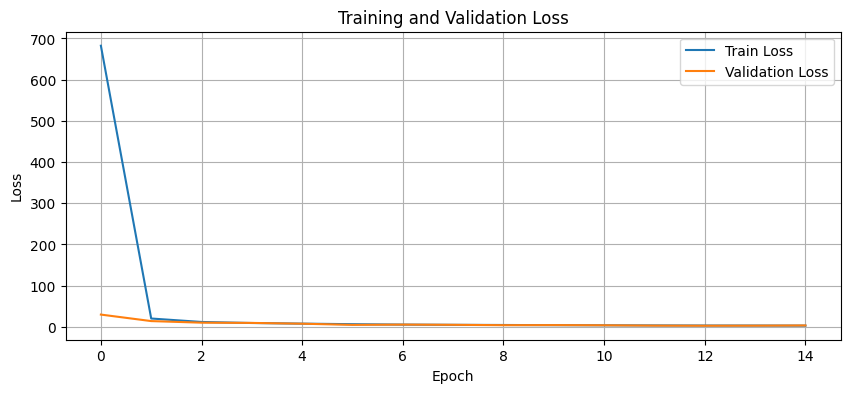

([682.2096698527433,
  20.218859507113088,
  11.860359659000318,
  9.30450760588354,
  7.7956898893628805,
  6.450521673474993,
  5.471734372936949,
  4.929712932936999,
  4.520450107905329,
  4.080264106088755,
  3.7577579653992945,
  3.4693328774705225,
  3.2296744341752968,
  3.167388704358315,
  2.9177963782329948],
 [29.765942429051254,
  13.974755735108346,
  10.098445747837875,
  9.537525552691836,
  7.623037020365397,
  4.767165256269051,
  5.470032301816073,
  4.918819991025058,
  4.030129049763535,
  4.217106378439701,
  3.771128762852062,
  2.972526434696082,
  2.7248327406969937,
  2.879242286537633,
  3.397236274950432])

In [172]:
# Initialize the Transformer model
config = {
    'n_notes': 47,
    'd_model': 256, 
    'dropout': 0.1,
    'n_decoder_layers': 4,
    'n_heads': 8,
    'batch_size': 32
}

# Training loop
num_epochs = 15

model = Transformer(**config)
# device = torch.device('cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)  # Fixed: uncommented this line

print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
print(f"Training on device: {device}")

criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

   
# Run training
train_model(model=model, train_loader=train_set, valid_loader=valid_set,  optimizer=optimizer, criterion=criterion, epochs=num_epochs, device=device)

In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (src, tgt) in enumerate(test_loader): 
            src, tgt = src.to(device), tgt.to(device)
            
            decoder_input = tgt[:, :-1]  
            decoder_target = tgt[:, 1:] 
            
            # Forward pass: encoder gets source, decoder gets shifted target
            outputs = model(decoder_input)
            
            # Reshape for cross entropy loss
            outputs_flat = outputs.reshape(-1, outputs.size(-1))
            decoder_target_flat = decoder_target.reshape(-1)
            
            loss = criterion(outputs_flat, decoder_target_flat)
            total_loss += loss.item()

            # Calculate accuracy
            _, predicted = outputs_flat.max(1)
            total += decoder_target_flat.size(0)
            correct += predicted.eq(decoder_target_flat).sum().item()
        
        avg_loss = total_loss / len(test_loader)
        accuracy = 100. * correct / total
    
        print(f'Test Results:')
        print(f'Test Loss: {avg_loss:.4f}')
        print(f'Test Accuracy: {accuracy:.2f}%')
        
    return avg_loss, accuracy

    
# Evaluate the model on test set
test_loss, test_acc = evaluate_model(model, test_set, criterion, device)

In [136]:
def generate_chorale(model, seed_chords, length=32):
    model.eval()  # Set model to evaluation mode
    
    with torch.no_grad():  # Disable gradient computation for inference
        # Convert seed chords to tensor and preprocess
        seed_tensor = torch.tensor(seed_chords, dtype=torch.long)
        arpegio = preprocess(seed_tensor)
        arpegio = arpegio.unsqueeze(0).to(device)  # Add batch dimension and move to device
        
        # Generate new notes
        for chord in range(length):
            for note in range(4):
            
                # Get model prediction for the current sequence
                outputs = model(arpegio)  # Shape: (1, seq_len, n_notes)
                
                # Get the prediction for the last timestep
                last_output = outputs[0, -1, :]  # Shape: (n_notes,)
                
                # Get the most likely next note
                next_note = torch.argmax(last_output, dim=-1, keepdim=True)  # Shape: (1,)
                
                # Append the predicted note to the sequence
                arpegio = torch.cat([arpegio, next_note.unsqueeze(0)], dim=1)

        # Convert back to original note range (reverse the preprocessing)
        arpegio = torch.where(arpegio == 0, arpegio, arpegio + min_note - 1)
        
        # Reshape to chord format (group every 4 notes)
        arpegio_flat = arpegio.squeeze(0)  # Remove batch dimension
        n_total_notes = len(arpegio_flat)
        n_complete_chords = n_total_notes // 4
        
        # Take only complete chords and reshape
        chorale = arpegio_flat[:n_complete_chords * 4].reshape(-1, 4)
        
        return chorale.cpu().numpy()  # Convert back to numpy for compatibility

In [137]:
seed_chords = test_chorales[2][:12]
baroque_synth.play_chorale(seed_chords)            

In [138]:
new_chorale = generate_chorale(model, seed_chords, length=32)
baroque_synth.play_chorale(new_chorale)
print("Generated Chorale:")
print(new_chorale[12:])

Generated Chorale:
[[73 64 57 57]
 [73 64 57 57]
 [73 64 57 57]
 [73 64 57 57]
 [73 64 57 57]
 [73 64 57 57]
 [73 64 57 57]
 [73 64 57 57]
 [74 66 62 59]
 [74 66 62 59]
 [74 66 62 59]
 [74 66 62 59]
 [76 67 62 59]
 [76 67 62 59]
 [76 67 62 59]
 [76 67 62 59]
 [76 67 60 60]
 [76 67 60 60]
 [76 67 60 60]
 [76 67 60 60]
 [74 69 60 60]
 [60 60 60 52]
 [76 67 60 60]
 [60 60 60 60]
 [60 60 60 60]
 [60  0 77 69]
 [60 77 69 60]
 [57 77 69 60]
 [60 60 60 57]
 [36 76 67 60]
 [60 60 74 67]
 [60 60 57 76]]


## Analyzing Transformer vs RNN Performance

### Key Differences to Highlight:

1. **Attention Mechanism**: 
   - Transformer can attend to any position in the sequence simultaneously
   - RNN processes sequentially, potentially losing long-term dependencies

2. **Parallelization**: 
   - Transformer training can be parallelized (all positions at once)
   - RNN training is inherently sequential

3. **Musical Structure**:
   - Transformer might better capture harmonic relationships across time
   - Can potentially learn chord progressions and voice leading patterns

4. **Generation Quality**:
   - Compare coherence of generated chorales
   - Look at harmonic consistency and voice independence

### Exercises for Students:

1. **Experiment with attention heads**: Try different numbers of attention heads and see how it affects generation quality

2. **Temperature sampling**: Adjust the temperature parameter to control randomness vs structure

3. **Seed analysis**: Try different seed sequences and observe how the model continues them

4. **Attention visualization**: Plot attention weights to see what the model focuses on (advanced)